Module and DataSet import

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cbook import boxplot_stats
import scipy.stats as stats
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVR
from sklearn.decomposition import PCA


SEED = 14

df = pd.read_csv('Universities.csv')
df = df.drop(columns='Unnamed: 0')

Generate generic statistic - transform %-string into float

In [2]:
def statistic(df: pd.DataFrame):
    name = [] 
    type = [] 
    rows = [] 
    unique = [] 
    missing = []
    
    for column in df.columns:
        name.append(column)
        if (df[column].dtype == object):
            if (df[column].str.contains('%').any()):
                df[column] = df[column].str.rstrip('%').astype('float') / 100.0
        type.append(df[column].dtype)
        rows.append(len(df[column]))
        unique.append(len(df[column].dropna().unique()))
        missing.append(df[column].isna().sum())
    
    statistic = pd.DataFrame({
        'name': name, 
        'type': type,
        'rows': rows,
        'unique': unique,
        'missing': missing 
    })    
    return statistic

statistic(df)

,name,type,rows,unique,missing
0,University_name,object,145,118,14
1,Region,object,145,12,0
2,Founded_year,float64,145,60,15
3,Motto,object,145,113,18
4,UK_rank,int64,145,119,0
5,World_rank,int64,145,130,0
6,CWUR_score,float64,145,73,52
7,Minimum_IELTS_score,float64,145,5,0
8,UG_average_fees_(in_pounds),int64,145,83,0
9,PG_average_fees_(in_pounds),int64,145,80,0


Deduplication

In [3]:
def deduplication(df : pd.DataFrame):
    duplicated_rows = df.index[df['Latitude'].duplicated()].to_list()
    df.drop(duplicated_rows, axis=0, inplace=True)
    return df

deduplication(df)
statistic(df)

,name,type,rows,unique,missing
0,University_name,object,131,118,13
1,Region,object,131,12,0
2,Founded_year,float64,131,60,14
3,Motto,object,131,113,17
4,UK_rank,int64,131,119,0
5,World_rank,int64,131,130,0
6,CWUR_score,float64,131,73,47
7,Minimum_IELTS_score,float64,131,5,0
8,UG_average_fees_(in_pounds),int64,131,83,0
9,PG_average_fees_(in_pounds),int64,131,80,0


Data manipulation and Export

In [4]:
df['Founded_year'] = df['Founded_year'].replace(9999, np.NaN)
df['Student_satisfaction'] = df['Student_satisfaction'].replace(0.0, np.NaN)
df.to_csv(r'cleaned_data.csv', index=False, header=True)

Remove unnecessary columns and split the dataframe into numeric and non-numeric columns for analysis

In [5]:
useless_columns = np.array(['University_name', 'Motto', 'Website'])
df_useful = df.drop(columns=useless_columns)

df_numeric = df_useful.select_dtypes(include=["float", 'int'])
df_non_numeric = df_useful.select_dtypes(exclude=["float", 'int'])

Boxplots

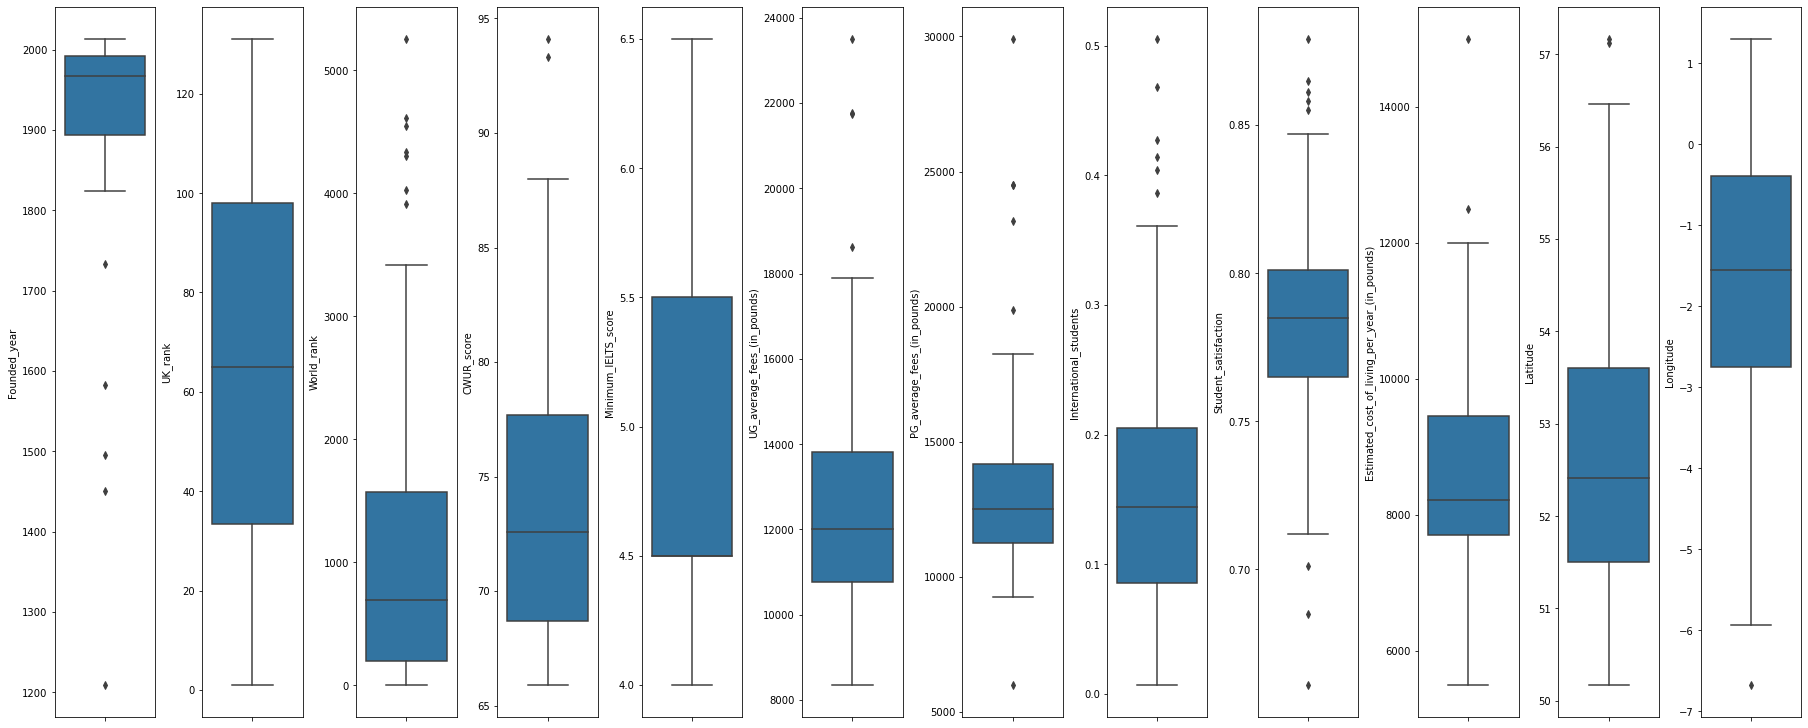

In [6]:
names = df_numeric.columns
ncols = len(names)
fig, axes = plt.subplots(1, ncols, figsize=(25, 10), constrained_layout = True)

for i, name in enumerate(names):
    sns.boxplot(y=name, data=df_numeric, orient='y', ax=axes[i])

plt.show()

Important statistics (numerical df)

In [7]:
def statistical_values(df: pd.DataFrame):
    name = []
    q1 = []
    q3 = []
    iqr = []
    mean = []
    median = []
    min = []
    max = []
    modal = []
    outlier = []

    for column in df.columns:
        q1_value = df[column].quantile(0.25)
        q3_value = df[column].quantile(0.75)
        iqr_value = q3_value - q1_value

        outlier_list = []
        for value in df[column]:
            if (value < (q1_value - 1.5 * iqr_value)) | (value > (q3_value + 1.5 * iqr_value)):
                outlier_list.append(value)
        outlier_list = pd.unique(outlier_list)
        
        name.append(column)
        q1.append(q1_value)
        q3.append(q3_value)
        iqr.append(iqr_value)
        mean.append(df[column].mean())
        median.append(df[column].median())
        min.append(df[column].min())
        max.append(df[column].max())
        modal.append(df[column].value_counts().idxmax())
        outlier.append(outlier_list)
    
    statistic = pd.DataFrame({
        'Column' : name,
        'Q1': q1, 
        'Q3': q3,
        'IQR': iqr,
        'mean': mean,
        'median': median, 
        'min' : min,
        'max' : max,
        'modal' : modal,
        'outlier' : outlier
    })    

    return statistic

statistical_values(df_numeric)


,Column,Q1,Q3,IQR,mean,median,min,max,modal,outlier
0,Founded_year,1893.5000,1992.00000,98.50000,1930.262136,1967.0000,1209.0000,2013.0000,1992.0000,"[1209.0, 1451.0, 1583.0, 1495.0, 1733.0]"
1,UK_rank,33.5000,98.00000,64.50000,65.900763,65.0000,1.0000,131.0000,102.0000,[]
2,World_rank,196.0000,1569.00000,1373.00000,1097.595420,691.0000,2.0000,5253.0000,196.0000,"[4300, 4608, 4336, 4547, 3916, 5253, 4030]"
3,CWUR_score,68.6750,77.70000,9.02500,73.960714,72.6000,65.9000,94.1000,77.7000,"[94.1, 93.3]"
4,Minimum_IELTS_score,4.5000,5.50000,1.00000,4.946565,4.5000,4.0000,6.5000,4.5000,[]
5,UG_average_fees_(in_pounds),10758.0000,13825.00000,3067.00000,12537.450382,12000.0000,8350.0000,23500.0000,10500.0000,"[21750, 21770, 23500, 18630]"
6,PG_average_fees_(in_pounds),11250.0000,14182.50000,2932.50000,13099.763359,12500.0000,6000.0000,29900.0000,12500.0000,"[23187, 19888, 29900, 24500, 6000]"
7,International_students,0.0860,0.20500,0.11900,0.155903,0.1440,0.0070,0.5050,0.1559,"[0.40399999999999997, 0.414, 0.467999999999999..."
8,Student_satisfaction,0.7650,0.80100,0.03600,0.783224,0.7850,0.6610,0.8790,0.7930,"[0.855, 0.865, 0.879, 0.858, 0.685, 0.861, 0.7..."
9,Estimated_cost_of_living_per_year_(in_pounds),7710.5000,9457.50000,1747.00000,8644.732824,8217.0000,5500.0000,15000.0000,8000.0000,"[12500, 15000]"


We assume that some outlier are errors and set them to NaN

In [8]:
#if you not already removed the outlier before
#df_numeric['Founded_year'] = df_numeric['Founded_year'].replace(9999, np.NaN)
#df_numeric['Student_satisfaction'] = df_numeric['Student_satisfaction'].replace(0.0, np.NaN)

#statistical_values(df_numeric)

Find correlations (Pearson, Spearman)

In [9]:
def create_corr_df(df : pd.DataFrame):
    featureA = []
    featureB = []
    linearCorrelation = []
    rankedCorrelation = []
    
    ncol = len(df.columns)
    for index_x in range(0, ncol):
        for index_y in range(0, ncol):
            lin_corr = round((df_numeric.iloc[:,index_x].corr(df_numeric.iloc[:,index_y])), 2)
            rank_corr = round((df_numeric.iloc[:,index_x].corr(df_numeric.iloc[:,index_y], method='spearman')), 2)
            featureA.append(df.columns[index_x])
            featureB.append(df.columns[index_y])
            linearCorrelation.append(lin_corr)
            rankedCorrelation.append(rank_corr)

    correlation = pd.DataFrame({
        'Feature A' : featureA,
        'Feature B' : featureB,
        'Pearson' : linearCorrelation,
        'Spearman' : rankedCorrelation
    })    

    return correlation

df_corr = create_corr_df(df_numeric)

correlation_bound = [-0.5, 0.5] 

df_corr[(((df_corr.Pearson > correlation_bound[1]) | (df_corr.Pearson < correlation_bound[0])) & (df_corr.Pearson != 1.0))] 


,Feature A,Feature B,Pearson,Spearman
3,Founded_year,CWUR_score,-0.56,-0.49
14,UK_rank,World_rank,0.53,0.73
15,UK_rank,CWUR_score,-0.75,-0.82
16,UK_rank,Minimum_IELTS_score,-0.66,-0.65
17,UK_rank,UG_average_fees_(in_pounds),-0.67,-0.73
18,UK_rank,PG_average_fees_(in_pounds),-0.64,-0.70
25,World_rank,UK_rank,0.53,0.73
27,World_rank,CWUR_score,-0.51,-0.87
29,World_rank,UG_average_fees_(in_pounds),-0.52,-0.77
30,World_rank,PG_average_fees_(in_pounds),-0.51,-0.76


own Train / Test Split method for imputation, avoid biased imputation

In [10]:
def split(df : pd.DataFrame, test_size : float):
    np.random.seed(SEED)
    size = len(df.index)
    test = test_size
    test_items = round(size * test)
    test_indices = np.random.choice(df.dropna().index, test_items, replace=False)
    test_indices
    train_indices = [i for i in range(size) if i not in test_indices]
    test_indices.sort()
    df_test = df.iloc[test_indices]
    df_train = df.iloc[train_indices]
    return df_train, df_test

Data Imputation

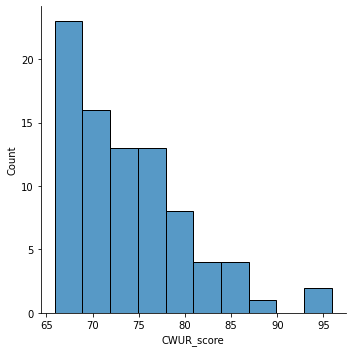

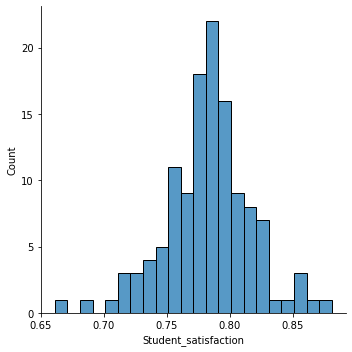

In [11]:
#checking the plots to decide weather we should use the mean or the median
sns.displot(data = df_numeric['CWUR_score'].dropna(), binwidth=3)
sns.displot(data = df_numeric['Student_satisfaction'], binwidth=0.01)

In [12]:
#build a regression model and calculate the missing values with the intercept and slope
def imputation_numeric(df: pd.DataFrame):
    lm = LinearRegression()
    df_regression = df[df['CWUR_score'].notna()]
    lm.fit(df_regression['UG_average_fees_(in_pounds)'].to_numpy().reshape(-1, 1), df_regression['CWUR_score'])
    slope = lm.coef_
    intercept = lm.intercept_

    for index, value in enumerate(df_numeric['UG_average_fees_(in_pounds)']):
        if(pd.isna(df.loc[index, 'CWUR_score'])):
            #switch between median or linear regression imputation
            df.loc[index, 'CWUR_score'] = (df.loc[index, 'UG_average_fees_(in_pounds)'] * slope + intercept)[0]
            #df.loc[index, 'CWUR_score'] = df['CWUR_score'].median()
        if(pd.isna(df_numeric.loc[index, 'Student_satisfaction'])):
            df.loc[index, 'Student_satisfaction'] = df['Student_satisfaction'].mean()


def imputation_founded_year(df : pd.DataFrame):
    nan_indices = np.where(df['Founded_year'].isna())
    founded_years = [1096, 1413, 1964, 1965, 1966, 1904, 1900, 1901, 1862, 1963, 1829, 1920,
                     1964, 1961, 1872, 1895, 1882, 1844, 1870, 1850, 1840, 1994, 1832, 1891,
                     1968, 2005, 1822, 2006]
    for index in nan_indices:
        df.loc[index, 'Founded_year'] = founded_years.pop(0)

def imputation_academic_calender(df: pd.DataFrame):
    mode = df['Academic_Calender'].value_counts().idxmax()
    df['Academic_Calender'] = df['Academic_Calender'].fillna(mode)

def imputation_campus_setting(df : pd.DataFrame):
    df_kmeans = df[['Latitude', 'Longitude', 'Campus_setting']].copy()

    test, train = split(df_kmeans, test_size=0.7)
    test_notna = test.dropna()
    train_X = train.drop(columns='Campus_setting')
    train_y = train['Campus_setting']
    test_X = test_notna.drop(columns='Campus_setting')
    test_y = test_notna['Campus_setting']
    
    kneighbors = KNeighborsClassifier(n_neighbors=4, p=2)
    kneighbors.fit(train_X, train_y)
    #print(kneighbors.score(test_X, test_y))
    
    predict_indices = np.where(df['Campus_setting'].isna())
    df_predict = test.drop(columns='Campus_setting').loc[predict_indices]
    predicted_values = kneighbors.predict(df_predict).tolist()
    for index in predict_indices:
        df.loc[index, 'Campus_setting'] = predicted_values.pop(0)

imputation_numeric(df_useful)
imputation_founded_year(df_useful)
imputation_academic_calender(df_useful)
imputation_campus_setting(df_useful)
statistic(df_useful)

df_useful.to_csv(r'preprocessed_data.csv', index=False, header=True)


Support Vector Regression - Predicting with support vector machine

In [13]:
df_model = pd.read_csv('preprocessed_data.csv')
target_name = ['PG_average_fees_(in_pounds)', 'UG_average_fees_(in_pounds)']
test_size = 0.2
for target in target_name:
    df_features = df_model.drop(columns=target)
    df_encoded_features = pd.DataFrame()
    for column in df_features.columns:
        if((df_features[column].dtype == 'int') | (df_features[column].dtype == 'float')):
            scaler = StandardScaler()
            df_num = pd.DataFrame(scaler.fit_transform(df_features[[column]]))
            df_encoded_features = pd.concat([df_encoded_features, df_num], axis=1)
        else:
            encoder = OneHotEncoder()
            df_cat = pd.DataFrame(encoder.fit_transform(df_features[[column]]).toarray())
            df_encoded_features = pd.concat([df_encoded_features, df_cat], axis=1)
    scaler_target = StandardScaler()
    df_target = scaler_target.fit_transform(df_model[target].array.reshape(-1, 1))

    X_train, X_test, y_train, y_test = train_test_split(df_encoded_features, df_target.ravel(), test_size=test_size, shuffle=True, random_state=SEED)
    svr = SVR(kernel='rbf')
    svr.fit(X_train, y_train)
    print(f'Target: {target}, Prediction Score: {svr.score(X_test, y_test)}')
    #print(scaler_target.inverse_transform(y_train))



Target: PG_average_fees_(in_pounds), Prediction Score: 0.673379620085386
Target: UG_average_fees_(in_pounds), Prediction Score: 0.7361639839538889
